Your task is to create a bert-base-classifier of vacancy areas based on their titles.

Each vacancy can have more than one area so it's **Multi-label classification** not Multiclass classification




In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from nltk.tokenize import word_tokenize
from string import punctuation
from tqdm import tqdm


import math
import random
import re
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Tuple, Dict

# импорты:
import torch
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, Dataset, SequentialSampler
import random
import transformers

# Try two or more different bert-like models(different berts, robertas etc. or any other transformer based model) (**2 points max**)
 your notebook should contain the training process of all your models!

In [ ]:
MODEL_NAME =  {'bert': 'google-bert/bert-base-uncased',
              'alberta': 'alberta-base',
               'electra': 'google/electra-base-discriminator'}
MAX_SEQ_LENGTH = 128
RESULT_MODEL_PATH = './model.pt'

In [ ]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 12
seed_everything(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
punctuation = set('!"$%&\'()*,-/:;<=>?@[\\]^_`{|}~') # убрал #

In [ ]:
def clean(text):
    return ' '.join([token.lower() for token in word_tokenize(text) if token not in punctuation])

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/zelcookie/DL_NLP_HW_3/refs/heads/main/dataset_2020.csv')
df.shape

(78909, 2)

In [ ]:
max_len = df.title.apply(len).max()

Each vacancy can have more than one area separated be space

Exapmle:

Malware Analyst for Imunify Security,analyst it_security

In [ ]:
df_train, df_test = train_test_split(df, train_size=0.9, random_state=42)
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=42)

# Finish TextClassificationDataset (**1 point max**)

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, bianizer, max_len):

        self.max_len = max_len
        self.data = data
        self.tokenizer = tokenizer
        self.sentences = [clean(sent) for sent in data.title.tolist()]
        self.labels = [labels.split() for labels in data.area.tolist()]
        self.bianiezer = bianizer
        self.labels_one_hot = torch.tensor(self.bianiezer.transform(self.labels), dtype=torch.float)
        # ToDo add if you need somethong else



    def __len__(self):

         return len(self.data)

    def __getitem__(self, idx):

          tokens = self.tokenizer(self.sentences[idx],
                                          padding='max_length',
                                          max_length=self.max_len,
                                          truncation=True,
                                          return_tensors='pt')

          input_ids = tokens["input_ids"].squeeze(0)
          attention_mask = tokens["attention_mask"].squeeze(0)
          label = self.labels_one_hot[idx]

          return input_ids, attention_mask, label


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")
binarizer = MultiLabelBinarizer()
labels_train = [labels.split() for labels in df_train.area.tolist()]
binarizer.fit(labels_train)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

MultiLabelBinarizer()

In [ ]:
batch_size = 128
max_len = 128
#  не нашел ответ на вопрос, зачем нужен RandomSampler когда в dataloader можно просто шаффлить на трейне

train_dataset = TextClassificationDataset(df_train, tokenizer, binarizer, max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader =  DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,)

valid_dataset = TextClassificationDataset(df_valid, tokenizer, binarizer, max_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataset = TextClassificationDataset(df_test, tokenizer, binarizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
class BertForMultilabel(nn.Module):
    def __init__(self,  num_labels: int):
        super().__init__()

        self.bert = transformers.BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)


    def train_bert(self, train_bert_flag=True):
      for param in self.bert.parameters():
		      param.requires_grad = train_bert_flag



    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

      bert_output = self.bert(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                            )

      last_hidden_state = bert_output.last_hidden_state # [bs, seqlen, hs]

      mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state) # [bs, sl] --> [bs, sl, 1]

      masked_output = last_hidden_state * mask # [bs, sl, hs]

      token_len = mask.sum(dim = 1) # bs

      x = masked_output.sum(dim = 1) / token_len # [bs, hs]

      x = self.dropout(x)
      x = self.classifier(x) #[bs, num_classes]
      return x

In [ ]:
num_labels = len(binarizer.classes_)
model = BertForMultilabel(num_labels)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMultilabel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Train your classifier with freezed bert and save model with the lowest val loss during training (**2 points max**)

print train/val loss after each epoch


In [ ]:
def eval_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [ ]:
def train(model, iterator,val_iterator, optimizer, criterion, epochs, scheduler, save_dir):
    metrics_dict = {}
    os.makedirs(save_dir, exist_ok=True)  # для чекпоинтов

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0
    early_stop_patience = 2

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, epochs + 1):

        model.train()
        total_loss = 0.0
        y_true_all, y_pred_all = [], []

        for batch_idx, (input_ids, attention_mask, labels) in tqdm(enumerate(iterator), total = len(iterator)):

            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = attention_mask.to(device)

            logits = model(input_ids, attention_mask)
            y_pred = logits_to_labels(logits)
            loss = criterion(logits, labels)

            y_true_all.extend(labels.cpu().numpy())
            y_pred_all.extend(y_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()


            if batch_idx % 100 == 0:
                current_f1 = eval_f1(y_true_all, y_pred_all)
                current_accuracy = accuracy_score(y_true_all, y_pred_all)
                print(f"Epoch {epoch}/{epochs}, Batch {batch_idx}, "
                      f"Loss: {loss.item():.4f}, "
                      f"F1: {current_f1:.4f}, Acc: {current_accuracy:.4f}")


            if batch_idx % 100 == 0 and batch_idx > 0:
                checkpoint = {
                    'epoch': epoch,
                    'batch': batch_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': loss.item()
                }
                torch.save(checkpoint, os.path.join(save_dir, f"checkpoint_epoch_{epoch}_batch_{batch_idx}.pth"))
                print(f"Checkpoint saved at epoch {epoch}, batch {batch_idx}")


        train_loss = total_loss / len(iterator)
        accuracy = accuracy_score(y_true_all, y_pred_all)
        f1 = eval_f1(y_true_all, y_pred_all)
        print(f"Epoch {epoch}/{epochs} | TrainLoss: {train_loss:.4f} | "
              f"TrainAcc: {accuracy:.4f} | TrainF1: {f1:.4f}")

        val_loss, val_accuracy = validate(model, val_iterator, criterion)
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append(accuracy)
        val_metrics.append(val_accuracy)
        metrics_dict[epoch] = {'train_loss' : train_loss, 'val_loss' : val_loss }

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"\nEarly stopping на эпохе {epoch}, лучшая валидационная loss {best_val_loss:.4f}")
                break

        plot_losses(train_losses, val_losses, train_metrics, val_metrics)


    print(pd.DataFrame(metrics_dict))
    return metrics_dict

In [ ]:
def validate(model, iterator, criterion):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()

    total_val_loss = 0.0
    val_y_true_all, val_y_pred_all = [], []

    with torch.no_grad():

        for batch_idx, (input_ids,attention_mask, labels) in enumerate(iterator):

            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = attention_mask.to(device)

            logits = model(input_ids, attention_mask)

            y_pred = logits_to_labels(logits)

            loss = criterion(logits, labels)

            total_val_loss += loss.item()

            val_y_true_all.extend(labels.cpu().numpy())
            val_y_pred_all.extend(y_pred)

        val_avg_loss = total_val_loss / len(iterator)
        val_accuracy = accuracy_score(val_y_true_all, val_y_pred_all)
        val_f1 = eval_f1(val_y_true_all, val_y_pred_all)

        print(f" VALLoss: {val_avg_loss:.4f} |"
                f"VALAcc: {val_accuracy:.4f} |  VALValidation F1: {val_f1:.4f}")
    return val_avg_loss, val_accuracy

In [ ]:
def logits_to_labels(logits):
    preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
    return preds.tolist()

In [ ]:
  def plot_losses(train_losses,val_losses,train_metrics,val_metrics):
        clear_output()
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
        axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="Train Metric")
        axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="Validation Metric")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Metric")
        axs[1].legend()
        plt.show()
        plt.tight_layout()
        # wandb.log({"loss_plot": wandb.Image(fig)})  # Логируем график в WandB

In [ ]:
num_labels = len(binarizer.classes_)
model = BertForMultilabel(num_labels)
model.to(device)

model.train_bert(False)

In [ ]:
from torch.optim.lr_scheduler import StepLR

epochs      =   5
criterion   =   torch.nn.BCEWithLogitsLoss()
optimizer   =   optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas=(0.9, 0.95))
scheduler   =   StepLR(optimizer, step_size=3, gamma=0.1)

<Figure size 640x480 with 0 Axes>

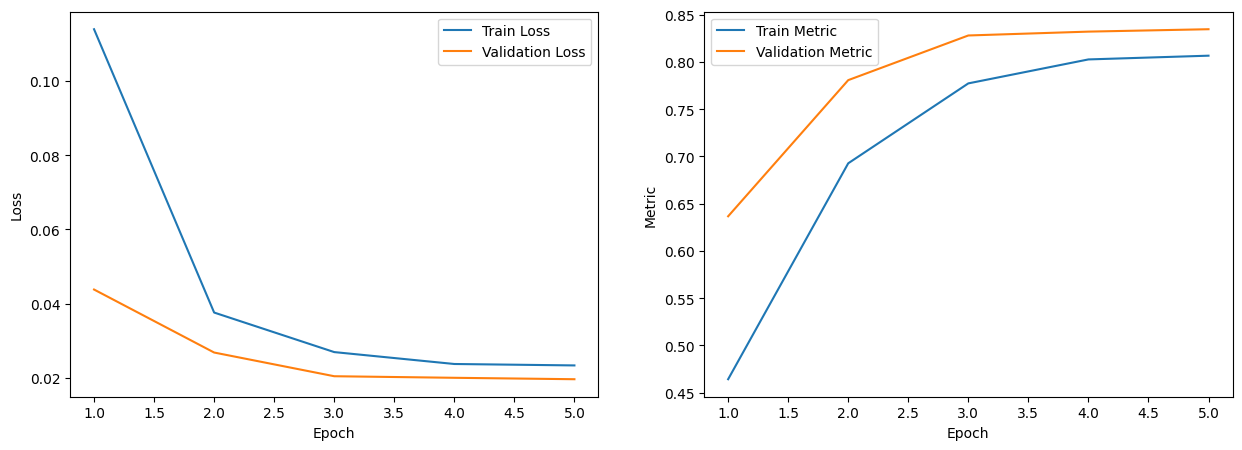

<Figure size 640x480 with 0 Axes>

In [ ]:
train(model, train_dataloader,valid_dataloader, optimizer, criterion, epochs, scheduler, 'checkpoints')
# def train(model, iterator,val_iterator optimizer, criterion, epochs, scheduler, save_dir):

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        logits = model(input_ids, attention_mask)
        batch_pred = logits_to_labels(logits)
        all_preds.extend(batch_pred)

In [ ]:
y_pred = np.array(all_preds)                  # форма (N, num_labels)
y_true = test_dataset.labels_one_hot.numpy()  # форма (N, num_labels)

print(classification_report(y_true, y_pred, target_names=binarizer.classes_))


                 precision    recall  f1-score   support

          admin       1.00      0.15      0.26        61
        analyst       0.96      0.90      0.93       302
    architector       1.00      0.31      0.47       111
      assistant       0.00      0.00      0.00        14
     consultant       0.00      0.00      0.00        23
          coord       0.00      0.00      0.00        11
  data_engineer       0.99      0.57      0.73       136
 data_scientist       0.98      0.77      0.86       154
       designer       0.98      0.91      0.94       409
devel_metodolog       1.00      0.75      0.86        44
         devops       1.00      0.97      0.98       338
       director       0.00      0.00      0.00        17
     doc_writer       1.00      0.67      0.80        18
    it_security       1.00      0.30      0.46        54
machine_learner       0.93      0.64      0.76        42
        manager       0.84      0.63      0.72       427
       networks       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ***ROBERT***

In [ ]:
class AlbertForMultilabel(nn.Module):
    def __init__(self,  num_labels: int):
        super().__init__()

        self.bert = transformers.AlbertModel.from_pretrained("albert-base-v2")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)


    def train_bert(self, train_bert_flag=True):
      for param in self.bert.parameters():
		      param.requires_grad = train_bert_flag



    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

      bert_output = self.bert(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                            )

      last_hidden_state = bert_output.last_hidden_state # [bs, seqlen, hs]

      mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state) # [bs, sl] --> [bs, sl, 1]

      masked_output = last_hidden_state * mask # [bs, sl, hs]

      token_len = mask.sum(dim = 1) # bs

      x = masked_output.sum(dim = 1) / token_len # [bs, hs]

      x = self.dropout(x)
      x = self.classifier(x) #[bs, num_classes]
      return x

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("albert/albert-base-v2")
binarizer = MultiLabelBinarizer()
labels_train = [labels.split() for labels in df_train.area.tolist()]
binarizer.fit(labels_train)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

MultiLabelBinarizer()

In [ ]:
batch_size = 128
max_len = 128
#  не нашел ответ на вопрос, зачем нужен RandomSampler когда в dataloader можно просто шаффлить на трейне

train_dataset = TextClassificationDataset(df_train, tokenizer, binarizer, max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader =  DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,)

valid_dataset = TextClassificationDataset(df_valid, tokenizer, binarizer, max_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataset = TextClassificationDataset(df_test, tokenizer, binarizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
num_labels = len(binarizer.classes_)
model = AlbertForMultilabel(num_labels)
model.to(device)
model.train_bert(False)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

In [ ]:
from torch.optim.lr_scheduler import StepLR

epochs      =   5
criterion   =   torch.nn.BCEWithLogitsLoss()
optimizer   =   optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas=(0.9, 0.95))
scheduler   =   StepLR(optimizer, step_size=3, gamma=0.1)

<Figure size 640x480 with 0 Axes>

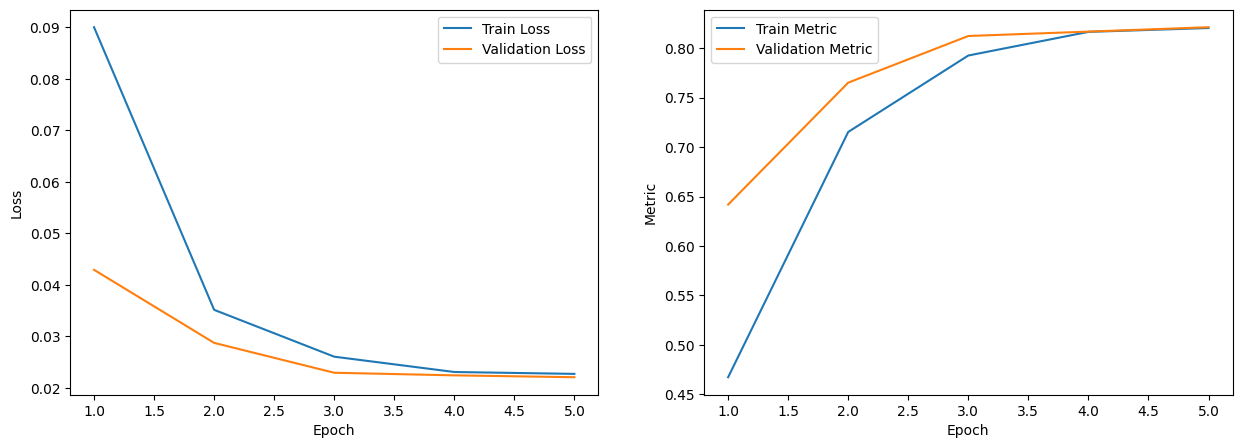

AttributeError: module 'pandas' has no attribute 'DataFrtame'

<Figure size 640x480 with 0 Axes>

In [ ]:
res = train(model, train_dataloader,valid_dataloader, optimizer, criterion, epochs, scheduler, 'checkpoints')

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        logits = model(input_ids, attention_mask)
        batch_pred = logits_to_labels(logits)
        all_preds.extend(batch_pred)

In [ ]:
y_pred = np.array(all_preds)
y_true = test_dataset.labels_one_hot.numpy()

print(classification_report(y_true, y_pred, target_names=binarizer.classes_))


                 precision    recall  f1-score   support

          admin       0.93      0.23      0.37        61
        analyst       0.99      0.83      0.90       302
    architector       1.00      0.29      0.45       111
      assistant       0.00      0.00      0.00        14
     consultant       0.00      0.00      0.00        23
          coord       0.00      0.00      0.00        11
  data_engineer       0.97      0.57      0.72       136
 data_scientist       0.98      0.84      0.91       154
       designer       0.97      0.78      0.87       409
devel_metodolog       1.00      0.61      0.76        44
         devops       1.00      0.93      0.96       338
       director       1.00      0.18      0.30        17
     doc_writer       1.00      0.72      0.84        18
    it_security       0.95      0.70      0.81        54
machine_learner       1.00      0.67      0.80        42
        manager       0.86      0.64      0.74       427
       networks       1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# *ELEKTRA*

In [ ]:
del model

In [ ]:
class ElektraForMultilabel(nn.Module):
    def __init__(self,  num_labels: int):
        super().__init__()

        self.bert = transformers.ElectraModel.from_pretrained("google/electra-base-discriminator")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)


    def train_bert(self, train_bert_flag=True):
      for param in self.bert.parameters():
		      param.requires_grad = train_bert_flag



    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

      bert_output = self.bert(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                            )

      last_hidden_state = bert_output.last_hidden_state # [bs, seqlen, hs]

      mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state) # [bs, sl] --> [bs, sl, 1]

      masked_output = last_hidden_state * mask # [bs, sl, hs]

      token_len = mask.sum(dim = 1) # bs

      x = masked_output.sum(dim = 1) / token_len # [bs, hs]

      x = self.dropout(x)
      x = self.classifier(x) #[bs, num_classes]
      return x

In [ ]:
tokenizer = transformers.ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator")
binarizer = MultiLabelBinarizer()
labels_train = [labels.split() for labels in df_train.area.tolist()]
binarizer.fit(labels_train)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

MultiLabelBinarizer()

In [ ]:
batch_size = 128
max_len = 128
#  не нашел ответ на вопрос, зачем нужен RandomSampler когда в dataloader можно просто шаффлить на трейне

train_dataset = TextClassificationDataset(df_train, tokenizer, binarizer, max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader =  DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,)

valid_dataset = TextClassificationDataset(df_valid, tokenizer, binarizer, max_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataset = TextClassificationDataset(df_test, tokenizer, binarizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
num_labels = len(binarizer.classes_)
model = ElektraForMultilabel(num_labels)
model.to(device)
model.train_bert(False)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from torch.optim.lr_scheduler import StepLR

epochs      =   5
criterion   =   torch.nn.BCEWithLogitsLoss()
optimizer   =   optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas=(0.9, 0.95))
scheduler   =   StepLR(optimizer, step_size=3, gamma=0.1)

<Figure size 640x480 with 0 Axes>

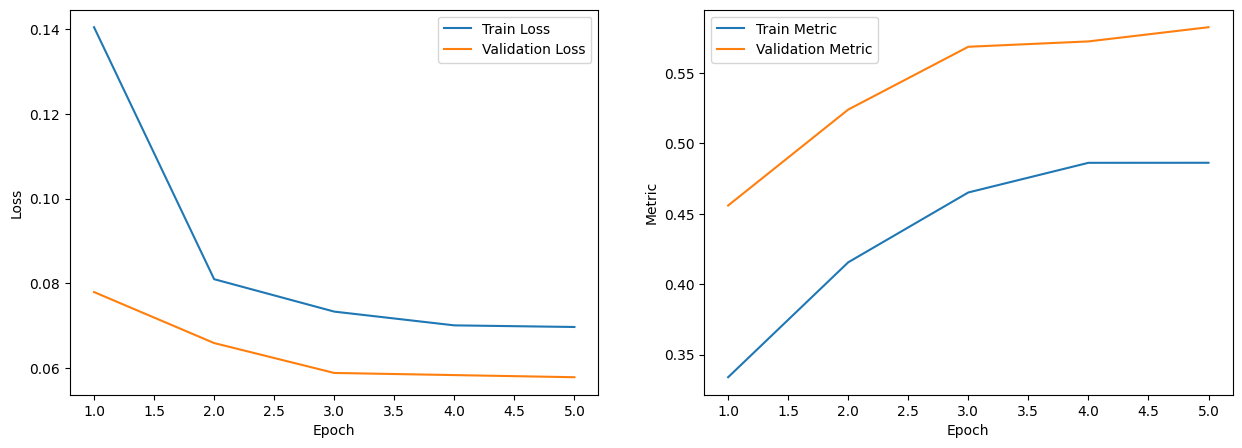

                   1         2         3         4         5
train_loss  0.140469  0.080936  0.073277  0.070024  0.069642
val_loss    0.077894  0.065844  0.058781  0.058276  0.057772


<Figure size 640x480 with 0 Axes>

In [ ]:
res = train(model, train_dataloader,valid_dataloader, optimizer, criterion, epochs, scheduler, 'checkpoints')

In [ ]:
pd.DataFrame(res).T

,train_loss,val_loss
1,0.140469,0.077894
2,0.080936,0.065844
3,0.073277,0.058781
4,0.070024,0.058276
5,0.069642,0.057772


In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        logits = model(input_ids, attention_mask)
        batch_pred = logits_to_labels(logits)
        all_preds.extend(batch_pred)

In [ ]:
y_pred = np.array(all_preds)                  # форма (N, num_labels)
y_true = test_dataset.labels_one_hot.numpy()  # форма (N, num_labels)

print(classification_report(y_true, y_pred, target_names=binarizer.classes_))

                 precision    recall  f1-score   support

          admin       0.00      0.00      0.00        61
        analyst       1.00      0.40      0.58       302
    architector       0.00      0.00      0.00       111
      assistant       0.00      0.00      0.00        14
     consultant       0.00      0.00      0.00        23
          coord       0.00      0.00      0.00        11
  data_engineer       1.00      0.42      0.59       136
 data_scientist       1.00      0.44      0.61       154
       designer       0.00      0.00      0.00       409
devel_metodolog       0.00      0.00      0.00        44
         devops       0.90      0.51      0.65       338
       director       0.00      0.00      0.00        17
     doc_writer       0.00      0.00      0.00        18
    it_security       0.00      0.00      0.00        54
machine_learner       0.00      0.00      0.00        42
        manager       1.00      0.07      0.14       427
       networks       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Train your classifier with unfreezed bert and save model with the lowest val loss during training (**2 points max**)

print train/val loss after each epoch

# ***А ТУТ РАДИ ИНТЕРЕСА И РАЗНООБРАЗИЯ НАПИШЕМ ОБОЛОЧКУ НА ЛАЙТНИНГЕ***

In [ ]:
# !pip install -U wandb -q
# !wandb login d03fe9a1d20b3e6b911e22c5188e07bf8bbc6e07

!pip install lightning -q
!pip install pytorch_lightning -q



import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pytorch_lightning as pl
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers

from collections import Counter
from collections import defaultdict, namedtuple
from nltk.tokenize import word_tokenize
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.tuner import Tuner
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, RandomSampler, Dataset, SequentialSampler
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score
from torchmetrics.functional import f1_score, accuracy
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict

nltk.download('punkt')
nltk.download('punkt_tab')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 43.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:

MODEL_NAME =  {'bert': 'google-bert/bert-base-uncased',
              'roberta': 'FacebookAI/xlm-roberta-base',
               'electra': 'google/electra-base-discriminator'}
MAX_SEQ_LENGTH = 128
RESULT_MODEL_PATH = './model.pt'

In [ ]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 12
seed_everything(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
punctuation = set('!"$%&\'()*,-/:;<=>?@[\\]^_`{|}~') # убрал #

In [ ]:
def clean(text):
    return ' '.join([token.lower() for token in word_tokenize(text) if token not in punctuation])

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/zelcookie/DL_NLP_HW_3/refs/heads/main/dataset_2020.csv')
df.shape

(78909, 2)

In [ ]:
max_len = df.title.apply(len).max()

In [ ]:
df_train, df_test = train_test_split(df, train_size=0.9, random_state=42)
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=42)

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, bianizer, max_len):

        self.max_len = max_len
        self.data = data
        self.tokenizer = tokenizer
        self.sentences = [clean(sent) for sent in data.title.tolist()]
        self.labels = [labels.split() for labels in data.area.tolist()]
        self.bianiezer = bianizer
        self.labels_one_hot = torch.tensor(self.bianiezer.transform(self.labels), dtype=torch.float)
        # ToDo add if you need somethong else



    def __len__(self):

         return len(self.data)

    def __getitem__(self, idx):

          tokens = self.tokenizer(self.sentences[idx],
                                          padding='max_length',
                                          max_length=self.max_len,
                                          truncation=True,
                                          return_tensors='pt')

          input_ids = tokens["input_ids"].squeeze(0)
          attention_mask = tokens["attention_mask"].squeeze(0)
          label = self.labels_one_hot[idx]

          return input_ids, attention_mask, label


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")
binarizer = MultiLabelBinarizer()
labels_train = [labels.split() for labels in df_train.area.tolist()]
binarizer.fit(labels_train)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

MultiLabelBinarizer()

In [ ]:
batch_size = 128
max_len = 128
#  не нашел ответ на вопрос, зачем нужен RandomSampler когда в dataloader можно просто шаффлить на трейне

train_dataset = TextClassificationDataset(df_train, tokenizer, binarizer, max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader =  DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,)

valid_dataset = TextClassificationDataset(df_valid, tokenizer, binarizer, max_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataset = TextClassificationDataset(df_test, tokenizer, binarizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
class BertForMultilabel(nn.Module):
    def __init__(self,  num_labels: int):
        super().__init__()

        self.bert = transformers.BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)


    def train_bert(self, train_bert_flag=True):
      for param in self.bert.parameters():
		      param.requires_grad = train_bert_flag



    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

      bert_output = self.bert(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                            )

      last_hidden_state = bert_output.last_hidden_state # [bs, seqlen, hs]

      mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state) # [bs, sl] --> [bs, sl, 1]

      masked_output = last_hidden_state * mask # [bs, sl, hs]

      token_len = mask.sum(dim = 1) # bs

      x = masked_output.sum(dim = 1) / token_len # [bs, hs]

      x = self.dropout(x)
      x = self.classifier(x) #[bs, num_classes]
      return x

In [ ]:
def logits_to_labels(logits):

    probs = torch.sigmoid(logits)
    return (probs > 0.5).int()

In [ ]:
num_labels = len(binarizer.classes_)

class ModelInference(pl.LightningModule):

    def __init__(self, model, lr, num_labels, num_training_steps, num_warmup_steps):
        super().__init__()
        self.model              = model
        self.lr                 = lr
        self.num_training_steps = num_training_steps
        self.num_warmup_steps   = num_warmup_steps
        self.criterion          = nn.BCEWithLogitsLoss()
        self.num_labels = num_labels

        self.train_f1  = MultilabelF1Score(num_labels=num_labels)
        self.val_f1    = MultilabelF1Score(num_labels=num_labels)
        self.train_acc = MultilabelAccuracy(num_labels=num_labels)
        self.val_acc   = MultilabelAccuracy(num_labels=num_labels)

        self.save_hyperparameters(ignore=["model"])



    def forward(self, input_ids, attention_mask):

        logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return logits

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
        param_optimizer = list(self.model.named_parameters())

        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.001,
            },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]


        optimizer = optim.AdamW(optimizer_grouped_parameters, lr=self.lr)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",   # шагать каждый step
            },
        }

    def _step(self, batch):

        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        y_pred = logits_to_labels(logits)
        y_true = labels.detach()

        return loss, y_pred, y_true

    def training_step(self, batch, batch_idx):

        loss, y_pred, y_true = self._step(batch)

        self.train_f1.update(y_pred, y_true)
        self.train_acc.update(y_pred, y_true)

        batch_f1 = f1_score(y_pred, y_true, task="multilabel", num_labels=self.num_labels)
        batch_acc = accuracy(y_pred, y_true, task="multilabel", num_labels=self.num_labels)

        self.log("train_f1_step", batch_f1, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_acc_step", batch_acc, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):

        loss, y_pred, y_true = self._step(batch)

        self.val_f1.update(y_pred, y_true)
        self.val_acc.update(y_pred, y_true)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_train_epoch_end(self):

        f1 = self.train_f1.compute()
        acc = self.train_acc.compute()

        self.log("train_f1_epoch", f1, prog_bar=True)
        self.log("train_acc_epoch", acc, prog_bar=True)

        self.train_f1.reset()
        self.train_acc.reset()

    def on_validation_epoch_end(self):

        f1 = self.val_f1.compute()
        acc = self.val_acc.compute()

        self.log("val_f1_epoch", f1, prog_bar=True)
        self.log("val_acc_epoch", acc, prog_bar=True)

        self.val_f1.reset()
        self.val_acc.reset()

In [ ]:
epochs = 10
lr = 2e-5
WARMUP_PROPORTION = 0.1


num_training_steps = len(train_dataloader) * epochs
warmup_steps = int(num_training_steps * WARMUP_PROPORTION)

num_labels = len(binarizer.classes_)

model = BertForMultilabel(num_labels)
model.train_bert(True)
model.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMultilabel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
bert_model = ModelInference(
    model=model,
    lr=lr,
    num_labels=num_labels,
    num_training_steps=num_training_steps,
    num_warmup_steps=warmup_steps,
)

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(
    project="bert_multilabel_bert",
    name="bert_run_3",
    log_model=True
)

In [ ]:
save_dir = '/content/checkpoints'

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
)

checkpoint_cb = ModelCheckpoint(
    dirpath=save_dir,
    filename="epoch{epoch:02d}-val_loss{val_loss:.4f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)

trainer = pl.Trainer(
    max_epochs=epochs,
    callbacks=[early_stop_cb, checkpoint_cb],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=wandb_logger
)

trainer.fit(
    bert_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: ss89629706152 (ss89629706152-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | BertForMultilabel  | 109 M  | train
1 | criterion | BCEWithLogitsLoss  | 0      | train
2 | train_f1  | MultilabelF1Score  | 0      | train
3 | val_f1    | MultilabelF1Score  | 0      | train
4 | train_acc | MultilabelAccuracy | 0      | train
5 | val_acc   | MultilabelAccuracy | 0      | train
---------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.018   Total estimated model params size (MB)
236       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 598, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1011, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1055, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 216, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 458, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/usr/local/lib/python3.12

TypeError: object of type 'NoneType' has no len()

In [ ]:
from google.colab import files
files.download("/content/checkpoints/epochepoch=02-val_lossval_loss=0.0070.ckpt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = ModelInference.load_from_checkpoint(
    "/content/checkpoints/epochepoch=02-val_lossval_loss=0.0132.ckpt",
    model=model,
    lr=0,
    num_labels=num_labels,
    num_training_steps=0,
    num_warmup_steps=0,
)

model.eval()
model.to(device)


all_preds = []
all_probas = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        logits = model(input_ids, attention_mask)
        probas = torch.sigmoid(logits)
        preds = (probas > 0.5).int()

        all_preds.append(preds.cpu())
        all_probas.append(probas.cpu())


In [ ]:
y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = test_dataset.labels_one_hot.numpy()

print(classification_report(y_true, y_pred, target_names=binarizer.classes_))

                 precision    recall  f1-score   support

          admin       1.00      0.95      0.97        61
        analyst       1.00      1.00      1.00       302
    architector       1.00      1.00      1.00       111
      assistant       1.00      1.00      1.00        14
     consultant       1.00      1.00      1.00        23
          coord       1.00      1.00      1.00        11
  data_engineer       1.00      1.00      1.00       136
 data_scientist       0.99      1.00      1.00       154
       designer       1.00      1.00      1.00       409
devel_metodolog       1.00      1.00      1.00        44
         devops       1.00      1.00      1.00       338
       director       1.00      1.00      1.00        17
     doc_writer       1.00      1.00      1.00        18
    it_security       1.00      0.98      0.99        54
machine_learner       1.00      1.00      1.00        42
        manager       1.00      0.99      1.00       427
       networks       1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# *`*ROBERT FULL TRAINING*`*

In [ ]:
# !pip install -U wandb -q
# !wandb login d03fe9a1d20b3e6b911e22c5188e07bf8bbc6e07

!pip install lightning -q
!pip install pytorch_lightning -q



import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pytorch_lightning as pl
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers

from collections import Counter
from collections import defaultdict, namedtuple
from nltk.tokenize import word_tokenize
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.tuner import Tuner
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, RandomSampler, Dataset, SequentialSampler
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score
from torchmetrics.functional import f1_score, accuracy
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict

nltk.download('punkt')
nltk.download('punkt_tab')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 51.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
punctuation = set('!"$%&\'()*,-/:;<=>?@[\\]^_`{|}~') # убрал #

In [ ]:
def clean(text):
    return ' '.join([token.lower() for token in word_tokenize(text) if token not in punctuation])

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/zelcookie/DL_NLP_HW_3/refs/heads/main/dataset_2020.csv')
df.shape

(78909, 2)

In [ ]:
max_len = df.title.apply(len).max()

In [ ]:
df_train, df_test = train_test_split(df, train_size=0.9, random_state=42)
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=42)

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, bianizer, max_len):

        self.max_len = max_len
        self.data = data
        self.tokenizer = tokenizer
        self.sentences = [clean(sent) for sent in data.title.tolist()]
        self.labels = [labels.split() for labels in data.area.tolist()]
        self.bianiezer = bianizer
        self.labels_one_hot = torch.tensor(self.bianiezer.transform(self.labels), dtype=torch.float)
        # ToDo add if you need somethong else



    def __len__(self):

         return len(self.data)

    def __getitem__(self, idx):

          tokens = self.tokenizer(self.sentences[idx],
                                          padding='max_length',
                                          max_length=self.max_len,
                                          truncation=True,
                                          return_tensors='pt')

          input_ids = tokens["input_ids"].squeeze(0)
          attention_mask = tokens["attention_mask"].squeeze(0)
          label = self.labels_one_hot[idx]

          return input_ids, attention_mask, label


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("albert/albert-base-v2")
binarizer = MultiLabelBinarizer()
labels_train = [labels.split() for labels in df_train.area.tolist()]
binarizer.fit(labels_train)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

MultiLabelBinarizer()

In [ ]:
batch_size = 64
max_len = 128
#  не нашел ответ на вопрос, зачем нужен RandomSampler когда в dataloader можно просто шаффлить на трейне

train_dataset = TextClassificationDataset(df_train, tokenizer, binarizer, max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader =  DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,)

valid_dataset = TextClassificationDataset(df_valid, tokenizer, binarizer, max_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataset = TextClassificationDataset(df_test, tokenizer, binarizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
class AlbertForMultilabel(nn.Module):
    def __init__(self,  num_labels: int):
        super().__init__()

        self.bert = transformers.AlbertModel.from_pretrained("albert-base-v2")
        # self.bert.gradient_checkpointing_enable()
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)


    def train_bert(self, train_bert_flag=True):
      for param in self.bert.parameters():
		      param.requires_grad = train_bert_flag



    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

      bert_output = self.bert(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                            )

      last_hidden_state = bert_output.last_hidden_state # [bs, seqlen, hs]

      mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state) # [bs, sl] --> [bs, sl, 1]

      masked_output = last_hidden_state * mask # [bs, sl, hs]

      token_len = mask.sum(dim = 1) # bs

      x = masked_output.sum(dim = 1) / token_len # [bs, hs]

      x = self.dropout(x)
      x = self.classifier(x) #[bs, num_classes]
      return x

In [ ]:
epochs = 3
lr = 2e-5
WARMUP_PROPORTION = 0.1


num_training_steps = len(train_dataloader) * epochs
warmup_steps = int(num_training_steps * WARMUP_PROPORTION)

num_labels = len(binarizer.classes_)

model = AlbertForMultilabel(num_labels)
model.train_bert(True)
model.train()


AlbertForMultilabel(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True

In [ ]:
def logits_to_labels(logits):

    probs = torch.sigmoid(logits)
    return (probs > 0.5).int()

In [ ]:
num_labels = len(binarizer.classes_)

class ModelInference(pl.LightningModule):

    def __init__(self, model, lr, num_labels, num_training_steps, num_warmup_steps):
        super().__init__()
        self.model              = model
        self.lr                 = lr
        self.num_training_steps = num_training_steps
        self.num_warmup_steps   = num_warmup_steps
        self.criterion          = nn.BCEWithLogitsLoss()
        self.num_labels = num_labels

        self.train_f1  = MultilabelF1Score(num_labels=num_labels)
        self.val_f1    = MultilabelF1Score(num_labels=num_labels)
        self.train_acc = MultilabelAccuracy(num_labels=num_labels)
        self.val_acc   = MultilabelAccuracy(num_labels=num_labels)

        self.save_hyperparameters(ignore=["model"])



    def forward(self, input_ids, attention_mask):

        logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return logits

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
        param_optimizer = list(self.model.named_parameters())

        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.001,
            },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]


        optimizer = optim.AdamW(optimizer_grouped_parameters, lr=self.lr)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

    def _step(self, batch):

        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        y_pred = logits_to_labels(logits)
        y_true = labels.detach()

        return loss, y_pred, y_true

    def training_step(self, batch, batch_idx):

        loss, y_pred, y_true = self._step(batch)

        self.train_f1.update(y_pred, y_true)
        self.train_acc.update(y_pred, y_true)

        batch_f1 = f1_score(y_pred, y_true, task="multilabel", num_labels=self.num_labels)
        batch_acc = accuracy(y_pred, y_true, task="multilabel", num_labels=self.num_labels)

        self.log("train_f1_step", batch_f1, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_acc_step", batch_acc, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):

        loss, y_pred, y_true = self._step(batch)

        self.val_f1.update(y_pred, y_true)
        self.val_acc.update(y_pred, y_true)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_train_epoch_end(self):

        f1 = self.train_f1.compute()
        acc = self.train_acc.compute()

        self.log("train_f1_epoch", f1, prog_bar=True)
        self.log("train_acc_epoch", acc, prog_bar=True)

        self.train_f1.reset()
        self.train_acc.reset()

    def on_validation_epoch_end(self):

        f1 = self.val_f1.compute()
        acc = self.val_acc.compute()

        self.log("val_f1_epoch", f1, prog_bar=True)
        self.log("val_acc_epoch", acc, prog_bar=True)

        self.val_f1.reset()
        self.val_acc.reset()

In [ ]:
class LossLogger(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_steps  = []

        self.train_f1_steps = []
        self.val_f1_epochs = []
        self.val_f1_steps = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):

        loss = outputs["loss"]
        self.train_losses.append(loss.detach().cpu().item())

        f1 = trainer.callback_metrics.get("train_f1_step")
        if f1 is not None:
            self.train_f1_steps.append(f1.detach().cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):

        loss = trainer.callback_metrics["val_loss"]
        self.val_losses.append(loss.detach().cpu().item())
        self.val_steps.append(len(self.train_losses))

        f1 = trainer.callback_metrics.get("val_f1_epoch")
        if f1 is not None:
            self.val_f1_epochs.append(f1.detach().cpu().item())
            self.val_f1_steps.append(len(self.train_f1_steps))


In [ ]:
def plot_history(train_losses, val_losses, val_steps):

    plt.figure(figsize=(6,4))

    plt.plot(train_losses, color="red", linewidth=1, label="train")
    plt.plot(val_steps, val_losses, "o-", color="blue", label="val")

    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_f1(train_f1, val_f1, val_steps):


    plt.figure(figsize=(6,4))

    plt.plot(train_f1, color="red", linewidth=1, label="train f1")
    plt.plot(val_steps, val_f1, "o-", color="blue", label="val f1")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
class PlotCallback(pl.Callback):
    def __init__(self, logger):
        self.logger = logger

    def on_train_epoch_end(self, trainer, pl_module):
        from IPython.display import clear_output
        clear_output(wait=True)

        plot_history(
            self.logger.train_losses,
            self.logger.val_losses,
            self.logger.val_steps
        )

        plot_f1(
            self.logger.train_f1_steps,
            self.logger.val_f1_epochs,
            self.logger.val_f1_steps
        )


In [ ]:
albert_model = ModelInference(
    model=model,
    lr=lr,
    num_labels=num_labels,
    num_training_steps=num_training_steps,
    num_warmup_steps=warmup_steps,
)

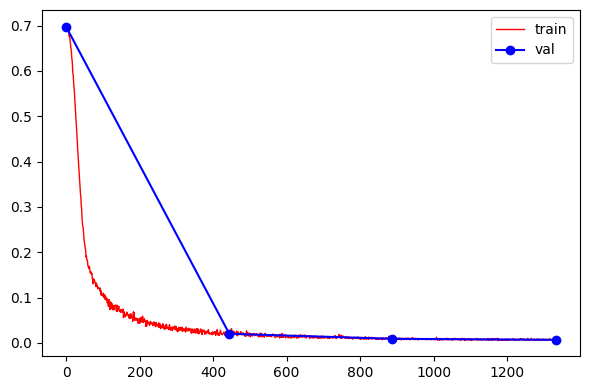

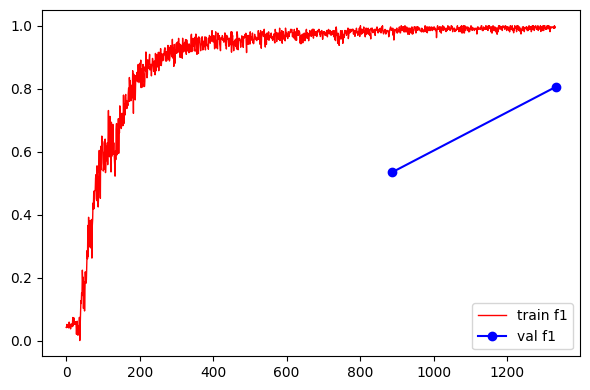

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
save_dir = '/content/checkpoints'

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
)

checkpoint_cb = ModelCheckpoint(
    dirpath=save_dir,
    filename="epoch{epoch:02d}-val_loss{val_loss:.4f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)
loss_logger = LossLogger()
trainer = pl.Trainer(
    precision=16,
    max_epochs=epochs,
    callbacks=[early_stop_cb, checkpoint_cb, loss_logger, PlotCallback(loss_logger)],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)




trainer.fit(
    albert_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)


In [ ]:
model = ModelInference.load_from_checkpoint(
    "/content/checkpoints/epochepoch=02-val_lossval_loss=0.0070.ckpt",
    model=model,
    lr=0,
    num_labels=num_labels,
    num_training_steps=0,
    num_warmup_steps=0,
)

model.eval()
model.to(device)


all_preds = []
all_probas = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        logits = model(input_ids, attention_mask)
        probas = torch.sigmoid(logits)
        preds = (probas > 0.5).int()

        all_preds.append(preds.cpu())
        all_probas.append(probas.cpu())


In [ ]:
y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = test_dataset.labels_one_hot.numpy()

print(classification_report(y_true, y_pred, target_names=binarizer.classes_))

                 precision    recall  f1-score   support

          admin       1.00      0.98      0.99        61
        analyst       1.00      1.00      1.00       302
    architector       1.00      0.98      0.99       111
      assistant       0.89      0.57      0.70        14
     consultant       0.94      0.65      0.77        23
          coord       1.00      1.00      1.00        11
  data_engineer       1.00      0.99      0.99       136
 data_scientist       0.99      0.97      0.98       154
       designer       1.00      0.99      0.99       409
devel_metodolog       1.00      0.98      0.99        44
         devops       1.00      0.99      0.99       338
       director       1.00      0.94      0.97        17
     doc_writer       1.00      0.94      0.97        18
    it_security       1.00      0.87      0.93        54
machine_learner       1.00      0.76      0.86        42
        manager       0.99      1.00      0.99       427
       networks       1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## ELEKTRA

In [1]:
# !pip install -U wandb -q
# !wandb login d03fe9a1d20b3e6b911e22c5188e07bf8bbc6e07

!pip install lightning -q
!pip install pytorch_lightning -q



import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pytorch_lightning as pl
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers

from collections import Counter
from collections import defaultdict, namedtuple
from nltk.tokenize import word_tokenize
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.tuner import Tuner
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, RandomSampler, Dataset, SequentialSampler
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score
from torchmetrics.functional import f1_score, accuracy
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict

nltk.download('punkt')
nltk.download('punkt_tab')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 21.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
punctuation = set('!"$%&\'()*,-/:;<=>?@[\\]^_`{|}~') # убрал #

In [5]:
def clean(text):
    return ' '.join([token.lower() for token in word_tokenize(text) if token not in punctuation])

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/zelcookie/DL_NLP_HW_3/refs/heads/main/dataset_2020.csv')
df.shape

(78909, 2)

In [7]:
max_len = df.title.apply(len).max()

In [8]:
df_train, df_test = train_test_split(df, train_size=0.9, random_state=42)
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=42)

In [9]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, bianizer, max_len):

        self.max_len = max_len
        self.data = data
        self.tokenizer = tokenizer
        self.sentences = [clean(sent) for sent in data.title.tolist()]
        self.labels = [labels.split() for labels in data.area.tolist()]
        self.bianiezer = bianizer
        self.labels_one_hot = torch.tensor(self.bianiezer.transform(self.labels), dtype=torch.float)
        # ToDo add if you need somethong else



    def __len__(self):

         return len(self.data)

    def __getitem__(self, idx):

          tokens = self.tokenizer(self.sentences[idx],
                                          padding='max_length',
                                          max_length=self.max_len,
                                          truncation=True,
                                          return_tensors='pt')

          input_ids = tokens["input_ids"].squeeze(0)
          attention_mask = tokens["attention_mask"].squeeze(0)
          label = self.labels_one_hot[idx]

          return input_ids, attention_mask, label


In [11]:
tokenizer = transformers.AutoTokenizer.from_pretrained("google/electra-base-discriminator")
binarizer = MultiLabelBinarizer()
labels_train = [labels.split() for labels in df_train.area.tolist()]
binarizer.fit(labels_train)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

MultiLabelBinarizer()

In [12]:
batch_size = 64
max_len = 128
#  не нашел ответ на вопрос, зачем нужен RandomSampler когда в dataloader можно просто шаффлить на трейне

train_dataset = TextClassificationDataset(df_train, tokenizer, binarizer, max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader =  DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,)

valid_dataset = TextClassificationDataset(df_valid, tokenizer, binarizer, max_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataset = TextClassificationDataset(df_test, tokenizer, binarizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [15]:
class ElektraForMultilabel(nn.Module):
    def __init__(self,  num_labels: int):
        super().__init__()

        self.bert = transformers.ElectraModel.from_pretrained("google/electra-base-discriminator")
        # self.bert.gradient_checkpointing_enable()
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)


    def train_bert(self, train_bert_flag=True):
      for param in self.bert.parameters():
		      param.requires_grad = train_bert_flag



    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

      bert_output = self.bert(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                            )

      last_hidden_state = bert_output.last_hidden_state # [bs, seqlen, hs]

      mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state) # [bs, sl] --> [bs, sl, 1]

      masked_output = last_hidden_state * mask # [bs, sl, hs]

      token_len = mask.sum(dim = 1) # bs

      x = masked_output.sum(dim = 1) / token_len # [bs, hs]

      x = self.dropout(x)
      x = self.classifier(x) #[bs, num_classes]
      return x

In [16]:
epochs = 5
lr = 2e-5
WARMUP_PROPORTION = 0.1


num_training_steps = len(train_dataloader) * epochs
warmup_steps = int(num_training_steps * WARMUP_PROPORTION)

num_labels = len(binarizer.classes_)

model = ElektraForMultilabel(num_labels)
model.train_bert(True)
model.train()


ElektraForMultilabel(
  (bert): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [17]:
def logits_to_labels(logits):

    probs = torch.sigmoid(logits)
    return (probs > 0.5).int()

In [18]:
num_labels = len(binarizer.classes_)

class ModelInference(pl.LightningModule):

    def __init__(self, model, lr, num_labels, num_training_steps, num_warmup_steps):
        super().__init__()
        self.model              = model
        self.lr                 = lr
        self.num_training_steps = num_training_steps
        self.num_warmup_steps   = num_warmup_steps
        self.criterion          = nn.BCEWithLogitsLoss()
        self.num_labels = num_labels

        self.train_f1  = MultilabelF1Score(num_labels=num_labels)
        self.val_f1    = MultilabelF1Score(num_labels=num_labels)
        self.train_acc = MultilabelAccuracy(num_labels=num_labels)
        self.val_acc   = MultilabelAccuracy(num_labels=num_labels)

        self.save_hyperparameters(ignore=["model"])



    def forward(self, input_ids, attention_mask):

        logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return logits

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
        param_optimizer = list(self.model.named_parameters())

        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.001,
            },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]


        optimizer = optim.AdamW(optimizer_grouped_parameters, lr=self.lr)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

    def _step(self, batch):

        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        y_pred = logits_to_labels(logits)
        y_true = labels.detach()

        return loss, y_pred, y_true

    def training_step(self, batch, batch_idx):

        loss, y_pred, y_true = self._step(batch)

        self.train_f1.update(y_pred, y_true)
        self.train_acc.update(y_pred, y_true)

        batch_f1 = f1_score(y_pred, y_true, task="multilabel", num_labels=self.num_labels)
        batch_acc = accuracy(y_pred, y_true, task="multilabel", num_labels=self.num_labels)

        self.log("train_f1_step", batch_f1, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_acc_step", batch_acc, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):

        loss, y_pred, y_true = self._step(batch)

        self.val_f1.update(y_pred, y_true)
        self.val_acc.update(y_pred, y_true)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_train_epoch_end(self):

        f1 = self.train_f1.compute()
        acc = self.train_acc.compute()

        self.log("train_f1_epoch", f1, prog_bar=True)
        self.log("train_acc_epoch", acc, prog_bar=True)

        self.train_f1.reset()
        self.train_acc.reset()

    def on_validation_epoch_end(self):

        f1 = self.val_f1.compute()
        acc = self.val_acc.compute()

        self.log("val_f1_epoch", f1, prog_bar=True)
        self.log("val_acc_epoch", acc, prog_bar=True)

        self.val_f1.reset()
        self.val_acc.reset()

In [19]:
class LossLogger(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_steps  = []

        self.train_f1_steps = []
        self.val_f1_epochs = []
        self.val_f1_steps = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):

        loss = outputs["loss"]
        self.train_losses.append(loss.detach().cpu().item())

        f1 = trainer.callback_metrics.get("train_f1_step")
        if f1 is not None:
            self.train_f1_steps.append(f1.detach().cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):

        loss = trainer.callback_metrics["val_loss"]
        self.val_losses.append(loss.detach().cpu().item())
        self.val_steps.append(len(self.train_losses))

        f1 = trainer.callback_metrics.get("val_f1_epoch")
        if f1 is not None:
            self.val_f1_epochs.append(f1.detach().cpu().item())
            self.val_f1_steps.append(len(self.train_f1_steps))


In [20]:
def plot_history(train_losses, val_losses, val_steps):

    plt.figure(figsize=(6,4))

    plt.plot(train_losses, color="red", linewidth=1, label="train")
    plt.plot(val_steps, val_losses, "o-", color="blue", label="val")

    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
def plot_f1(train_f1, val_f1, val_steps):


    plt.figure(figsize=(6,4))

    plt.plot(train_f1, color="red", linewidth=1, label="train f1")
    plt.plot(val_steps, val_f1, "o-", color="blue", label="val f1")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
class PlotCallback(pl.Callback):
    def __init__(self, logger):
        self.logger = logger

    def on_train_epoch_end(self, trainer, pl_module):
        from IPython.display import clear_output
        clear_output(wait=True)

        plot_history(
            self.logger.train_losses,
            self.logger.val_losses,
            self.logger.val_steps
        )

        plot_f1(
            self.logger.train_f1_steps,
            self.logger.val_f1_epochs,
            self.logger.val_f1_steps
        )


In [23]:
elektra_model = ModelInference(
    model=model,
    lr=lr,
    num_labels=num_labels,
    num_training_steps=num_training_steps,
    num_warmup_steps=warmup_steps,
)

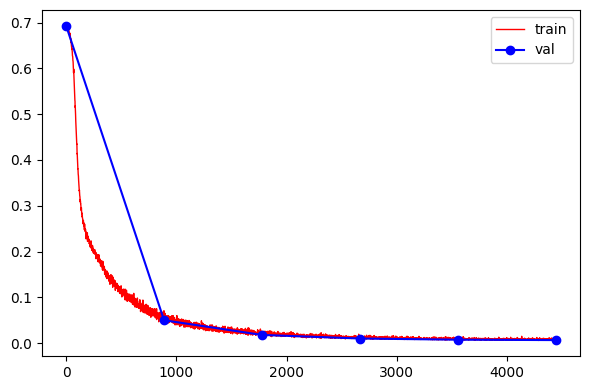

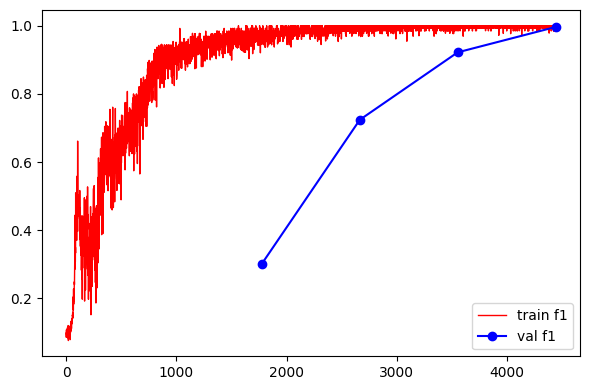

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [24]:
save_dir = '/content/checkpoints'

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
)

checkpoint_cb = ModelCheckpoint(
    dirpath=save_dir,
    filename="epoch{epoch:02d}-val_loss{val_loss:.4f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)
loss_logger = LossLogger()
trainer = pl.Trainer(
    max_epochs=epochs,
    callbacks=[early_stop_cb, checkpoint_cb, loss_logger, PlotCallback(loss_logger)],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)




trainer.fit(
    elektra_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)


In [25]:
from google.colab import files
files.download("/content/checkpoints/epochepoch=04-val_lossval_loss=0.0065.ckpt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
model = ModelInference.load_from_checkpoint(
    "/content/checkpoints/epochepoch=04-val_lossval_loss=0.0065.ckpt",
    model=model,
    lr=0,
    num_labels=num_labels,
    num_training_steps=0,
    num_warmup_steps=0,
)

model.eval()
model.to(device)


all_preds = []
all_probas = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        logits = model(input_ids, attention_mask)
        probas = torch.sigmoid(logits)
        preds = (probas > 0.5).int()

        all_preds.append(preds.cpu())
        all_probas.append(probas.cpu())


In [27]:
y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = test_dataset.labels_one_hot.numpy()

print(classification_report(y_true, y_pred, target_names=binarizer.classes_))

                 precision    recall  f1-score   support

          admin       1.00      1.00      1.00        61
        analyst       1.00      1.00      1.00       302
    architector       1.00      1.00      1.00       111
      assistant       1.00      0.93      0.96        14
     consultant       1.00      1.00      1.00        23
          coord       1.00      1.00      1.00        11
  data_engineer       1.00      1.00      1.00       136
 data_scientist       1.00      1.00      1.00       154
       designer       1.00      1.00      1.00       409
devel_metodolog       1.00      1.00      1.00        44
         devops       1.00      1.00      1.00       338
       director       1.00      1.00      1.00        17
     doc_writer       1.00      1.00      1.00        18
    it_security       1.00      1.00      1.00        54
machine_learner       1.00      1.00      1.00        42
        manager       1.00      1.00      1.00       427
       networks       1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Results

# Results (3 points max)

Write your conclusion

What models and what training parameters did you use?

What was the reason for your choice?

What were the results?

What metrics do you consider the most important?

Выводы:


*   Дообучение только головы классификатора недостатончо для эффективного решения задачи, и при более менее достаточно объемной выборке имеет смысл дообучать модель целиком, результаты явно хуже чам у просто tf-idf, а значит использовать такое решение бессмысленно
*   Полный файн-тьюнинг хорошо справился и все модели (вторая недообучена) выдали 1 по ф1 на тесте, что очень хорошо. Думаю, самое рациональное было, не дообучать всю модель, а только разморозить час весов на последних слоях. По ощущениям, так мы могли бы достичь оптимального качества и утилизации ресурсов
*    Я тестировал 3 модели (берт, альберта, электра). Насчет 3 я думал, надо будет дообучать и генератор и дискриминатор, однако оказалось, что для файнтьюнинга достаточно только дообучить дискриминатор классиечким образом. Для всех моделей использовались одинаковые параметры обучения: AdamW с lr 2e-5, 3-5 эпох, BCEWithLogitsLoss, Linear Warmup Scheduler.
*    Я считаю, самой важной метрикой является ф1, как наиболее обьективная метрика при дисбаланск классов.


*   Что касается weight_decay, он применяется только к тем слоям, где нам важно чтобы веса не переобучались, а bias и layernorm как раз нормализуют распределения данных и применение weight decay просто сломает эти слои и модель будет хуже сходиться



In [ ]:
MODEL_NAME =  {'bert': 'google-bert/bert-base-uncased',
              'alberta': 'alberta-base',
               'electra': 'google/electra-base-discriminator'}